<a href="https://colab.research.google.com/github/anandvardhan09/Bitcoin_Price_Predictor/blob/main/BTC_Price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Set the ticker symbol for Bitcoin, which is 'BTC-USD'
ticker_symbol = 'BTC-USD'

period = '356d'
# # Define the start and end dates for the data
# start_date = '2024-01-01'
# end_date = '2024-02-13'

# Specify the interval as '1h' for hourly data
interval = '1d'




# Getting the BTC data

In [2]:
# Use yfinance to get historical data for Bitcoin with hourly interval
bitcoin_data = yf.download(ticker_symbol, period=period , interval=interval)

bitcoin_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-14,26788.974609,27150.976562,26661.355469,26930.638672,26930.638672,10014858959
2023-05-15,26931.384766,27646.347656,26766.097656,27192.693359,27192.693359,14413231792
2023-05-16,27171.513672,27299.304688,26878.947266,27036.650391,27036.650391,12732238816
2023-05-17,27035.470703,27465.927734,26600.144531,27398.802734,27398.802734,15140006925
2023-05-18,27401.650391,27466.527344,26415.101562,26832.208984,26832.208984,15222938600
...,...,...,...,...,...,...
2024-04-29,63106.363281,64174.878906,61795.457031,63841.121094,63841.121094,26635912073
2024-04-30,63839.417969,64703.332031,59120.066406,60636.855469,60636.855469,37840840057
2024-05-01,60609.496094,60780.500000,56555.292969,58254.011719,58254.011719,48439780271


In [3]:
# Display the data types of each column in the bitcoin_data DataFrame
print(bitcoin_data.dtypes)

bitcoin_data.index

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


DatetimeIndex(['2023-05-14', '2023-05-15', '2023-05-16', '2023-05-17',
               '2023-05-18', '2023-05-19', '2023-05-20', '2023-05-21',
               '2023-05-22', '2023-05-23',
               ...
               '2024-04-24', '2024-04-25', '2024-04-26', '2024-04-27',
               '2024-04-28', '2024-04-29', '2024-04-30', '2024-05-01',
               '2024-05-02', '2024-05-03'],
              dtype='datetime64[ns]', name='Date', length=356, freq=None)

In [4]:
# Taking date as index and close column only
bitcoin_data = bitcoin_data[['Close']]

bitcoin_data

,Close
Date,
2023-05-14,26930.638672
2023-05-15,27192.693359
2023-05-16,27036.650391
2023-05-17,27398.802734
2023-05-18,26832.208984
...,...
2024-04-29,63841.121094
2024-04-30,60636.855469
2024-05-01,58254.011719


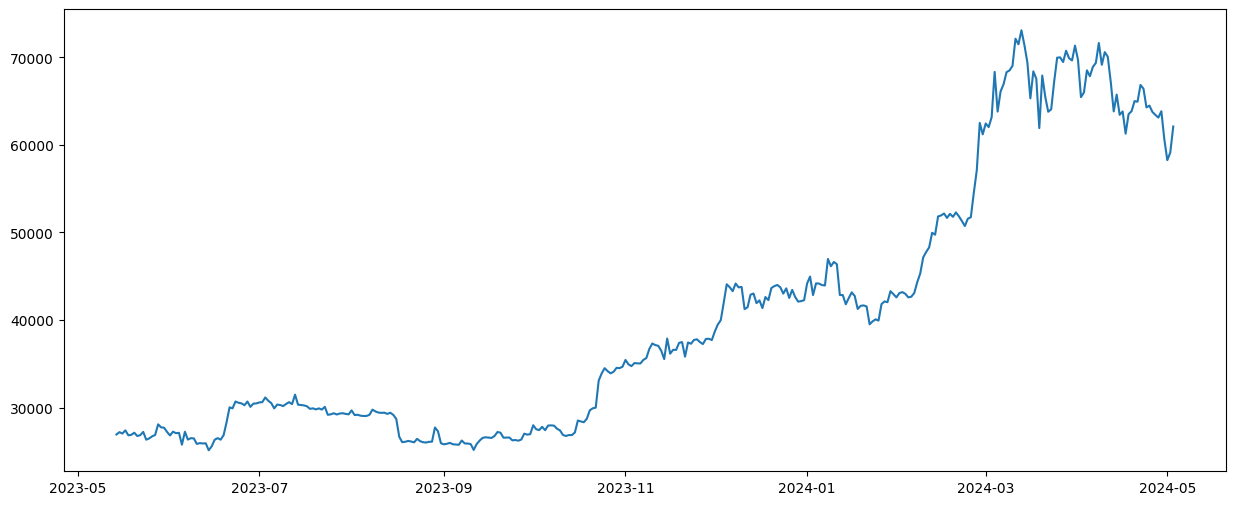

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(bitcoin_data.index, bitcoin_data['Close'])

# **LSTM Model**

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



# Extract the 'Close' prices for modeling
data = bitcoin_data[['Close']].values

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM model
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 10  # Number of previous time steps to consider for prediction
X, y = create_dataset(scaled_data, look_back)

# Reshape the input data to be 3D (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, epochs=50, batch_size=32)

# Predict using the trained model
test_data = scaled_data[len(scaled_data) - look_back:]
test_input = np.reshape(test_data, (1, look_back, 1))
predicted_price = model.predict(test_input)
predicted_price = scaler.inverse_transform(predicted_price)



Epoch 1/50
11/11 [==============================] - 6s 7ms/step - loss: 0.1050
Epoch 2/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0174
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0089
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 8/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 11/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 12/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 13/50
11/11 [==============================

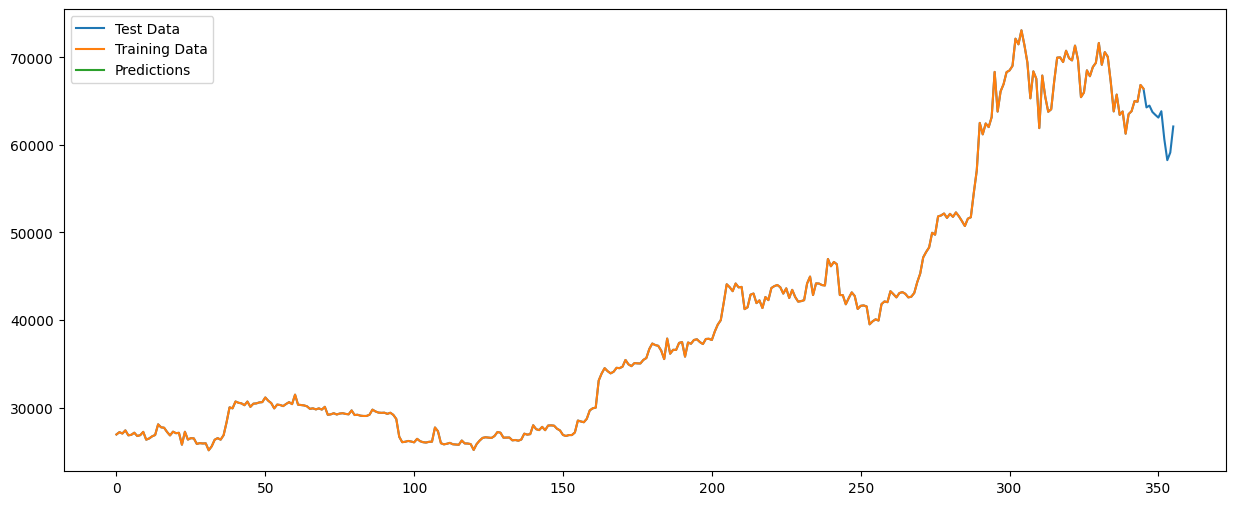

In [7]:
# Plotting the results
train = data[:len(data) - look_back]
test = data[len(data) - look_back:]

whole = np.append(train, test)
# test = pd.DataFrame(test)
# train = pd.DataFrame(train)


plt.figure(figsize=(15, 6))
plt.plot(whole, label='Test Data')
plt.plot(whole[:len(train)] , label='Training Data')
# plt.plot(whole[len(train):], label='Test Data')
plt.plot(predicted_price, label='Predictions')
plt.legend()
plt.show()

In [8]:
predicted_price

array([[61786.543]], dtype=float32)